# *** Data Exploration ***

# ***Load Samples***

In [7]:
import csv
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D
from keras.callbacks import TensorBoard
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn
import os

# log file directory name
DIR_NAME_TENSORFLOW_LOGS = "logs"

# simulator data file directory name
DIR_NAME_SIMULATOR_DATA = "simulator_data"

# the following PC_ values are used to 
# mark sample records for preprocessing
PC_CENTER_FLIPPED = 'CF'
PC_RIGHT = 'R'
PC_LEFT = 'L'
PC_CENTER = 'C'
PC_CORRECTION = .22


def load_samples(simulator_data_dir_name, add_flipped_images=True, add_left_right_camera_images=True, samples=None):
    if(samples is None):
        samples = []
    
    # loop through the sub directories under the top-level 
    # simulator directory and load log data
    for dir_name, subdir_list, file_list in os.walk(simulator_data_dir_name):
        for sub_dir_name in subdir_list:   
            log_dir_path = simulator_data_dir_name + "\\" + sub_dir_name
            log_file_path = log_dir_path + '\\driving_log.csv'                  
            with open(log_file_path) as csvfile:
                reader = csv.reader(csvfile)
                # loop through the log file adding a processing flag
                for line in reader:
                    # correct the image paths                    
                    for i in range(0,3):
                        path = line[i]                        
                        line[i] = log_dir_path + '\\IMG\\' + path.split('\\')[-1]                          
                        
                    if(add_flipped_images):                
                        samples.append(line + [PC_CENTER_FLIPPED])
                    if(add_left_right_camera_images):
                        samples.append(line + [PC_RIGHT])
                        samples.append(line + [PC_LEFT])            
                    samples.append(line + [PC_CENTER])
        break

    return samples

def get_line_image_and_angle(batch_sample):
    processing_code = batch_sample[-1]
                
    if(processing_code == PC_LEFT):                
        name = batch_sample[1]
        angle = float(batch_sample[3]) + PC_CORRECTION
    elif (processing_code == PC_RIGHT):                
        name = batch_sample[2]
        angle = float(batch_sample[3]) - PC_CORRECTION
    elif (processing_code == PC_CENTER):                
        name = batch_sample[0]
        angle = float(batch_sample[3])
    elif (processing_code == PC_CENTER_FLIPPED):                                
        name = batch_sample[0]
        angle = -float(batch_sample[3])

    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if(processing_code == PC_CENTER_FLIPPED):
        image = np.fliplr(image)   

    return image, angle

EPOCHS = 5
BATCH_SIZE = 500

# load sample data collected from multiple simulation runs
samples = load_samples(DIR_NAME_SIMULATOR_DATA)


# ***Summary***

In [8]:
center_measurements = 0
right_measurements = 0
left_measurements = 0
flipped_measurements = 0

for i, line in enumerate(samples):
    processing_code = line[-1]
    
    
    if(processing_code == PC_LEFT):                
        left_measurements += 1
    elif (processing_code == PC_RIGHT):                
        right_measurements += 1
    elif (processing_code == PC_CENTER):                
        center_measurements += 1
    elif (processing_code == PC_CENTER_FLIPPED):                                
        flipped_measurements += 1
        

total = center_measurements + right_measurements + left_measurements + flipped_measurements
print("The total number of measuresments (original and artificial):  " + str(total))
print("The total number of center measuresments  :  " + str(center_measurements))
print("The total number of left measuresments:  " + str(left_measurements))
print("The total number of right measuresments:  " + str(right_measurements))
print("The total number of flipped measuresments:  " + str(flipped_measurements))



The total number of measuresments (original and artificial):  91356
The total number of center measuresments  :  22839
The total number of left measuresments:  22839
The total number of right measuresments:  22839
The total number of flipped measuresments:  22839


# ***Output BGR2RGB Conversion Image Samples***

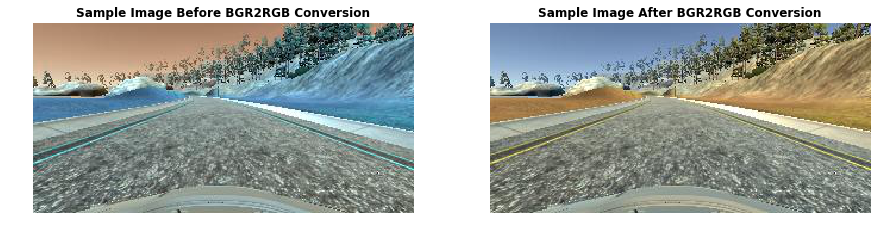

In [9]:
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

columns = 2
plt.figure(figsize=(15,50))
plt.subplot(1, 2, 1)   
plt.title("Sample Image Before BGR2RGB Conversion",fontdict={'weight':'bold','size': 12,})
plt.axis('off')

image = cv2.imread(samples[0][0])
plt.imshow(image) 

plt.subplot(1, 2, 2)   
plt.title("Sample Image After BGR2RGB Conversion",fontdict={'weight':'bold','size': 12,})
plt.axis('off')



image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 



# ***Create Histogram***

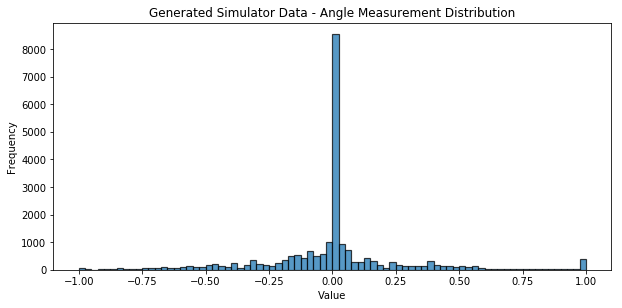

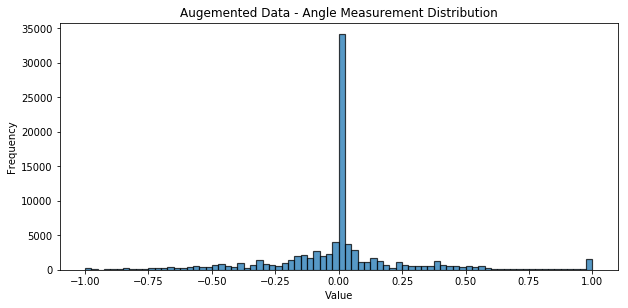

In [11]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

original_data = []
all_data = []

for i, line in enumerate(samples):
    if(line[-1] == PC_CENTER):
        original_data.append(float(line[3]))
    all_data.append((float(line[3])))
        


        
# the histogram of the original data
num_bins = 80
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)   
plt.title("Generated Simulator Data - Angle Measurement Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.hist(original_data, num_bins, alpha=0.75,edgecolor='black', linewidth=1.2)
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 2)   
plt.title("Augemented Data - Angle Measurement Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.hist(all_data, num_bins, alpha=0.75,edgecolor='black', linewidth=1.2)
plt.show()


# ***Image Flipped Example***

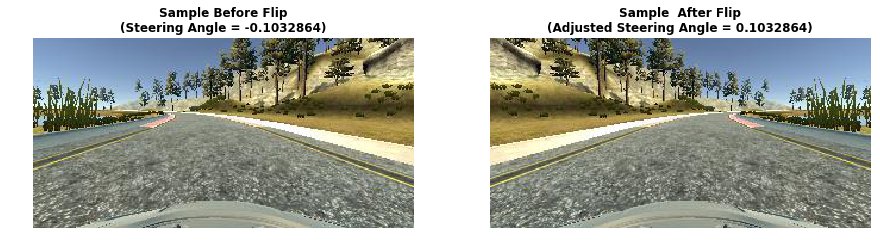

In [6]:


line = samples[1000]

columns = 2
plt.figure(figsize=(15,50))
plt.subplot(1, 2, 1)   
plt.title("Sample Before Flip\n(Steering Angle = " + str(line[3]) + ")",fontdict={'weight':'bold','size': 12,})
plt.axis('off')
image = cv2.imread(line[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 

plt.subplot(1, 2, 2)   
plt.title("Sample  After Flip\n(Adjusted Steering Angle = " + str(-float(line[3])) + ")",fontdict={'weight':'bold','size': 12,})
plt.axis('off')

image = np.fliplr(image)    
plt.imshow(image) 


# *** Image Cropping Example***

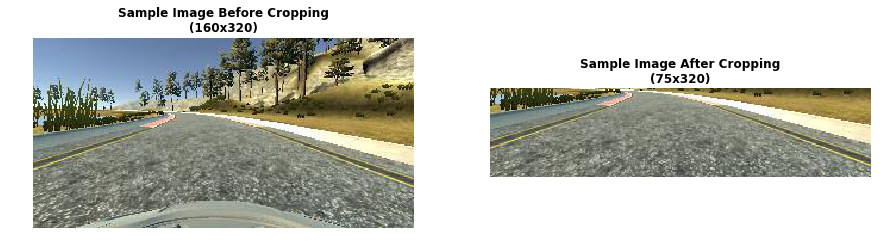

In [6]:
line = samples[1000]

crop_top = 60
crop_bottom = 25



columns = 2
plt.figure(figsize=(15,50))
plt.subplot(1, 2, 1)   
plt.title("Sample Image Before Cropping\n(160x320)",fontdict={'weight':'bold','size': 12,})
plt.axis('off')

image = cv2.imread(line[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 


y = image.shape[0]
x = image.shape[1]

cropped_image = image[crop_top:(y-crop_bottom), :, :]

new_height = y - (crop_top + crop_bottom)

plt.subplot(1, 2, 2)   
plt.axis('off')
plt.title("Sample Image After Cropping\n(" + str(new_height) + "x320)",fontdict={'weight':'bold','size': 12,})

plt.imshow(cropped_image) 


# ***Image Gray scale - edge detection***

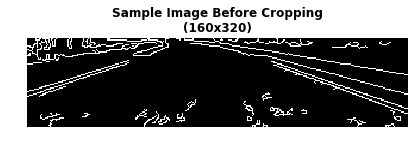

In [37]:
line = samples[1000]

crop_top = 60
crop_bottom = 25


columns = 2
plt.figure(figsize=(15,50))
plt.subplot(1, 2, 1)   
plt.title("Sample Image Before Cropping\n(160x320)",fontdict={'weight':'bold','size': 12,})
plt.axis('off')

image = cv2.imread(line[0])
image = image[crop_top:(y-crop_bottom), :, :]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (3,3),0)
image = cv2.Canny(image,100,255)
#image = cv2.Laplacian(image, cv2.CV_64F)



plt.imshow(image, cmap='gray') 
